# PyroLab 1 - Bayesian Linear Regression for Generative Learning with Pyro

## Objective

* To perform Bayesian linear regression using Pyro and PyTorch for understanding the fundamental concepts in generative models.

**Suggested reading**: 
* [Bayesian linear regression on Wiki](https://en.wikipedia.org/wiki/Bayesian_linear_regression)
* Bayesian linear regression (Section 3.3) in the [PRML book](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)

This notebook is based on [Pyro](http://pyro.ai/)'s official tutorials [An Introduction to Models in Pyro](http://pyro.ai/examples/intro_part_i.html) and [Bayesian Regression - Introduction (Part 1)](http://pyro.ai/examples/bayesian_regression.html), and Robert Ness's [Introduction to Generative ML with Pyro](https://github.com/robertness/causalML/blob/master/tutorials/1-introduction/2_intro_to_generative_ML_with_Pyro.ipynb). It is developed using Pyro versoin 1.5.1.

## Why

[**Generative models**](https://en.wikipedia.org/wiki/Generative_model) can estimate the probability of the instance, and also the probability of a class label. One of their important applications is [uncertainty quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification). 

We will start from the generative version of linear regression, our most basic machine learning model. The classic generative formulation of linear regression is called **Bayesian linear regression** or simply **Bayesian regression**.  

## 1. Pyro Basics

Pyro is a universal [probabilistic programming language (PPL)](https://en.wikipedia.org/wiki/Probabilistic_programming) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

#### Install [Pyro](https://github.com/pyro-ppl/pyro) with extra packages
`pip install pyro-ppl[extras]`

Get ready by importing APIs needed in this notebook

In [4]:
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule

pyro.set_rng_seed(2020)
# pyro.enable_validation(True)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

#### Models in Pyro

The basic unit of probabilistic programs is the _stochastic function_. This is an arbitrary Python callable that combines two ingredients:

- deterministic Python code; and
- primitive stochastic functions that call a random number generator

We will often call stochastic functions *models*, since stochastic functions can be used to represent simplified or abstract descriptions of a process by which data are **generated**. 

#### Primitive Stochastic Functions

Primitive stochastic functions, or distributions, are an important class of stochastic functions for which we can explicitly compute the probability of the outputs given the inputs. Pyro uses PyTorch's [distribution library](http://pytorch.org/docs/master/distributions.html). You can also create custom distributions using [transforms](http://pytorch.org/docs/master/distributions.html#module-torch.distributions.transforms).

Using primitive stochastic functions is easy. For example, to draw a sample `x` from the unit normal distribution $\mathcal{N}(0,1)$ we do the following:

In [5]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # log of the probability for the sample from N(0,1)

sample tensor(1.2372)
log prob tensor(-1.6843)


Pyro uses pyro.sample() to sample from distributions.

In [6]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-0.9604)


Just like a direct call to `torch.distributions.Normal().rsample()`, this returns a sample from the unit normal distribution. The **crucial difference** is that this sample is _named_. Pyro's backend uses these names to uniquely identify sample statements and _change their behavior at runtime_ depending on how the enclosing stochastic function is being used. As we will see, this is how Pyro can implement the various manipulations that underlie inference algorithms.

Let's write a simple `weather` model.

#### A simple model

In [7]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 74.04261016845703)
('sunny', 92.23351287841797)
('sunny', 38.940975189208984)


First two lines introduce a binary variable `cloudy`, which is given by a draw from the Bernoulli distribution with a parameter of $0.3$. The Bernoulli distribution returns either $0$ or $1$, line `2` converts that into a string. So, So according to this model, $30%$ of the time it’s cloudy and $70%$ of the time it’s sunny.

In line `4` and `5`, we initialize mean and scale of the temperature for both values. We then sample, the temperature from a Normal distribution and return that along with `cloudy` variable.


We can build complex model by modularizing and reusing the concepts into functions and use them as programmers use functions.

In [8]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

for _ in range(3):
    print(ice_cream_sales())

tensor(193.2412)
tensor(52.7703)
tensor(39.7493)


## 2. Bayesian Regression with Pyro's Stochastic Variational Inference (SVI)


### Dataset 

The following example is adapted from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[2\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
  
The response variable GDP is highly skewed, so we will log-transform it.

In [9]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

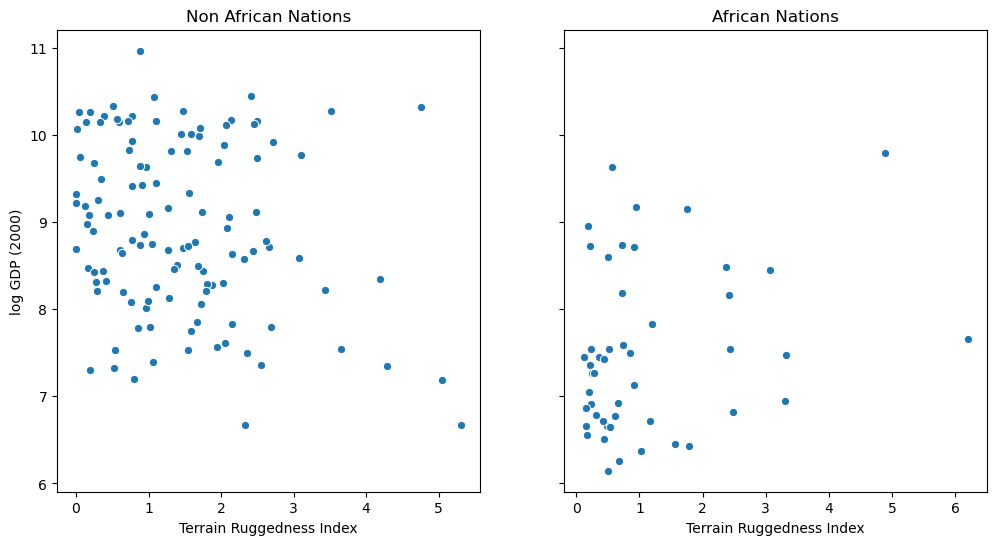

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            non_african_nations["rgdppc_2000"], 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
                african_nations["rgdppc_2000"], 
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Model

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

Making a Bayesian model for linear regression is very intuitive using `PyroModule` as earlier. Note the following:

 - The `BayesianRegression` module internally uses the same `PyroModule[nn.Linear]` module. However, note that we replace the `weight` and the `bias` of the this module with `PyroSample` statements. These statements allow us to place a prior over the `weight` and `bias` parameters, instead of treating them as fixed learnable parameters. For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.
 - The `BayesianRegression.forward` method specifies the generative process. We generate the mean value of the response by calling the `linear` module (which, as you saw, samples the `weight` and `bias` parameters from the prior and returns a value for the mean response). Finally we use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`. The model returns the regression line given by the variable `mean`.

In [11]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

### Using an AutoGuide

In order to do inference, i.e. learn the posterior distribution over our unobserved parameters, we will use Stochastic Variational Inference (SVI). The guide determines a family of distributions, and `SVI` aims to find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior. 

Users can write arbitrarily flexible custom guides in Pyro, but in this tutorial, we will restrict ourselves to Pyro's [autoguide library](http://docs.pyro.ai/en/dev/infer.autoguide.html). 

To begin with, we will use the `AutoDiagonalNormal` guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption(see [Bayesian Regression Part II](bayesian_regression_ii.ipynb)). Under the hood, this defines a `guide` that uses a `Normal` distribution with learnable parameters corresponding to each `sample` statement in the model. e.g. in our case, this distribution should have a size of `(5,)` correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and `sigma` in the model. 

Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/infer.autoguide.html) for more information).

In [12]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

### Optimizing the Evidence Lower Bound

We will use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)) for doing inference. Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [13]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

Note that we use the `Adam` optimizer from Pyro's `optim` module and not the `torch.optim` module as earlier. Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). Optimizers in `pyro.optim` are used to optimize and update parameter values in Pyro's parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the `SVI` class automatically. To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to `SVI.step` will be passed to both `model()` and `guide()`. The complete training loop is as follows:

In [14]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

pyro.clear_param_store()

num_iterations = 1500
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 200 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

C:\Users\eehpl\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[iteration 0001] loss: 3.0707
[iteration 0201] loss: 1.4595
[iteration 0401] loss: 1.4563
[iteration 0601] loss: 1.4572
[iteration 0801] loss: 1.4584
[iteration 1001] loss: 1.4626
[iteration 1201] loss: 1.4586
[iteration 1401] loss: 1.4803


We can examine the optimized parameter values by fetching from Pyro's param store.

In [24]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, 'AAA', pyro.param(name))

AutoDiagonalNormal.loc AAA Parameter containing:
tensor([-2.2685, -1.8670, -0.1556,  0.3606,  9.2119])
AutoDiagonalNormal.scale AAA tensor([0.0597, 0.1413, 0.0398, 0.0807, 0.0658])


As you can see, instead of just point estimates, we now have **uncertainty estimates** (`AutoDiagonalNormal.scale`) for our learned parameters. Note that Autoguide packs the latent variables into a single tensor, in this case, one entry per variable sampled in our model. Both the `loc` and `scale` parameters have size `(5,)`, one for each of the latent variables in the model, as we had remarked earlier.

To look at the distribution of the latent parameters more clearly, we can make use of the `AutoDiagonalNormal.quantiles` method which will unpack the latent samples from the autoguide, and automatically constrain them to the site's support (e.g. the variable `sigma` must lie in `(0, 10)`). 

In [16]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9040), tensor(0.9377), tensor(0.9725)],
 'linear.weight': [tensor([[-1.9622, -0.1825,  0.3062]]),
  tensor([[-1.8670, -0.1556,  0.3606]]),
  tensor([[-1.7717, -0.1288,  0.4151]])],
 'linear.bias': [tensor([9.1675]), tensor([9.2119]), tensor([9.2563])]}

## Model Evaluation

To evaluate our model, we'll **generate** some predictive samples and look at the posteriors. For this we will make use of the [Predictive](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive) utility class.

  - We generate 800 samples from our trained model. Internally, this is done by first generating samples for the unobserved sites in the `guide`, and then running the model forward by conditioning the sites to values sampled from the `guide`. 
  - Note that in `return_sites`, we specify both the outcome (`"obs"` site) as well as the return value of the model (`"_RETURN"`) which captures the regression line. Additionally, we would also like to capture the regression coefficients (given by `"linear.weight"`) for further analysis.
  - The remaining code is simply used to plot the 90% CI for the two variables from our model.

In [17]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, 
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [18]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

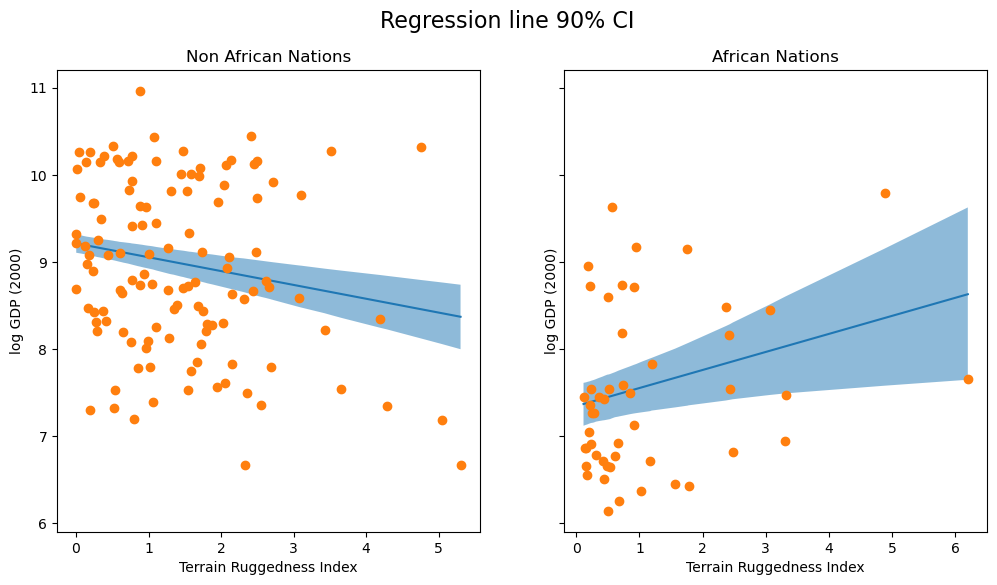

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

The above figure shows the uncertainty in our estimate of the regression line, and the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by `sigma`! Let us do so next.

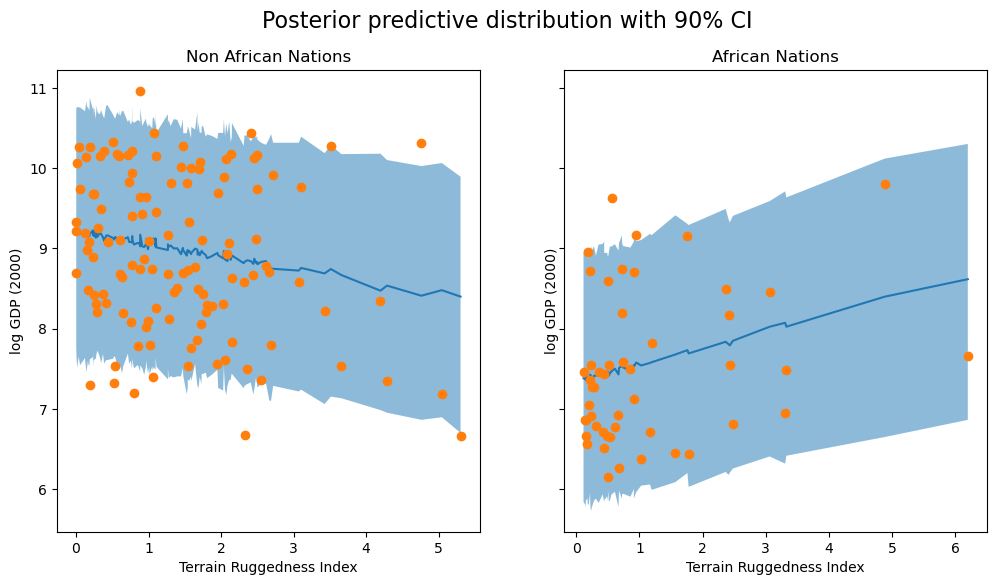

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions. 

Finally, let us revisit our earlier question of how robust the relationship between terrain ruggedness and GDP is against any uncertainty in the parameter estimates from our model. For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa. As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations, lending further credence to the original hypothesis. 

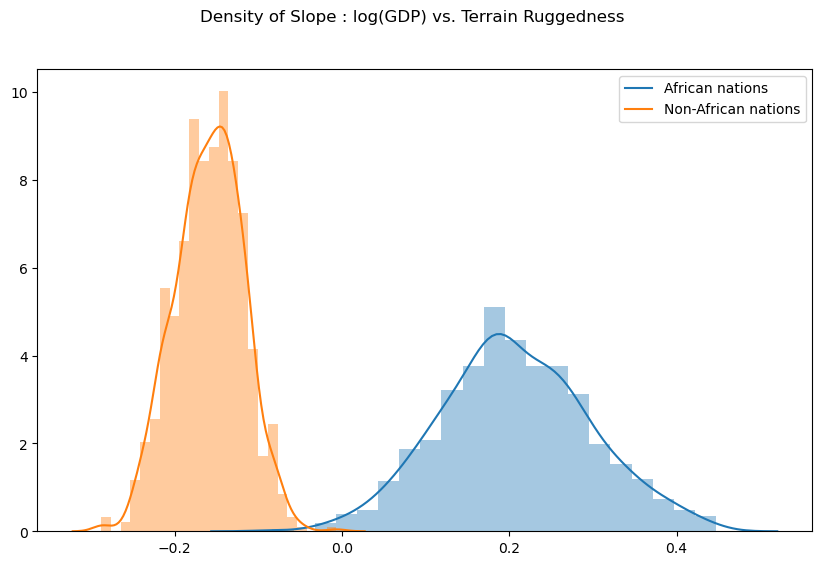

In [21]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## 3. Exercises


* Study the full [Bayesian Regression - Introduction (Part 1)](http://pyro.ai/examples/bayesian_regression.html).
* Study the more advanced [Bayesian Regression - Inference Algorithms (Part 2)](http://pyro.ai/examples/bayesian_regression_ii.html)

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012